In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob

from extract_data import extract_data
from extract_field_goals import extract_field_goals
from extract_kickoffs_and_possessions import extract_kickoffs_and_possessions
from extract_punts import extract_punts
from extract_third_downs import extract_third_downs

pd.set_option("display.max_rows", 50)
# pd.set_option('display.max_colwidth', -1)
%matplotlib inline

def curve_fit(x, y, smoothness=.5):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    results = lowess(y, x, is_sorted=True, frac=smoothness)
    return results[:, 1]

In [2]:
temp = []
data = []
subpxp = []
for year in range(2008,2018):    
    path ='D:/Groups/CalFootball_4thDown/NCAA-Football-Data/' + str(year) + 'PXP' # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
        subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
    data= pd.concat(temp, ignore_index=True)

# Extracting data
pxp = extract_data(data)

## convert clock time into decimal
pxp['clock_decimal'] = pxp['clock']

## Eliminate bad yardage
pxp['yrdline100'] = pxp['yrdline100'].astype(int)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
## Extracting possession and kickoffs (starting points)
ko_and_poss = extract_kickoffs_and_possessions(pxp.loc[badyard])
# Retrict to first and third quarters
first_and_third_qtr = (ko_and_poss['quarter'] == 1) | (ko_and_poss['quarter'] == 3)
ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]

## Extracting punts
punts = extract_punts(pxp)

## Extracting FG
fgs = extract_field_goals(pxp)

## Extracting Third-down
third_downs = extract_third_downs(pxp)


# 1. Expected Kickoff/Possession EPV (Yard vs. EPV)

In [14]:
# Restrict to kickoff events
ko = ko_and_poss_first_and_third['type'].isin(['Kickoff','Kickoff Return (Defense)','Kickoff Return Touchdown','Kickoff Return (Offense)'])
# Compute the average kickoff value
ekv = ko_and_poss_first_and_third.loc[ko]['PossessionValue'].mean()
print("Expected Kickoff Value: {:.3f} pts".format(ekv))

Expected Kickoff Value: -1.728 pts


In [5]:
# 1. Ignore kickoffs
# 2. Group by yardline 
# 3. Take the average of PossessionValue
# 4. Convert to DataFrame instead of Series
# 5. Make the index a column instead
possession_values = ko_and_poss_first_and_third.loc[~ko].\
    groupby('yrdline100')['PossessionValue'].\
    mean().\
    to_frame()
possession_values.columns = ['rEPV']   # Update column names
possession_values

,rEPV
yrdline100,
1,1.679012
2,2.846154
3,1.816327
4,2.927536
5,3.833333
6,3.247191
7,3.711864
8,3.721649
9,3.490566


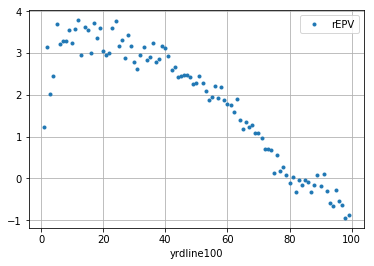

In [5]:
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
ax.grid()

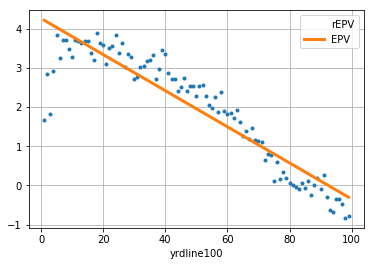

In [5]:
formula = 'rEPV ~ yrdline100'
results = smf.ols(formula, data=possession_values.reset_index()).fit()
# print(results.summary())

possession_values['EPV'] = results.fittedvalues.values
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
possession_values.plot(y='EPV', ax=ax, lw=3)
ax.grid()

epv_model = possession_values['EPV']

# 2.  Expected Conversion Percentage


In [6]:
conv_pct = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct.columns = ['rConvPct']  # update column names
conv_pct

rConvPct
yrdregion distance          
Inside10  0         0.950320
          1         0.620417
          2         0.500808
          3         0.421097
          4         0.375358
          5         0.314415
          6         0.275660
          7         0.289941
          8         0.251515
          9         0.177778
10to20    0         0.951024
          1         0.776161
          2         0.608043
          3         0.568195
          4         0.515242
          5         0.450704
          6         0.420495
          7         0.374189
          8         0.344005
          9         0.348856
Beyond20  0         0.900826
          1         0.759735
          2         0.632074
          3         0.562958
          4         0.533828
          5         0.480344
          6         0.443827
          7         0.411481
          8         0.381645
          9         0.363881

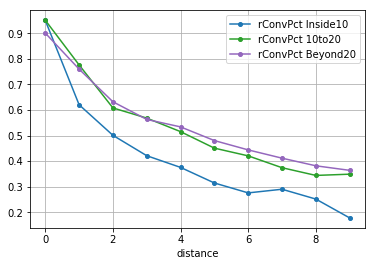

In [7]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C2', '10to20'), ('C4', 'Beyond20')]:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=color, marker='.', ms=8, label='rConvPct ' + region)

ax.legend(loc=1)
ax.grid()

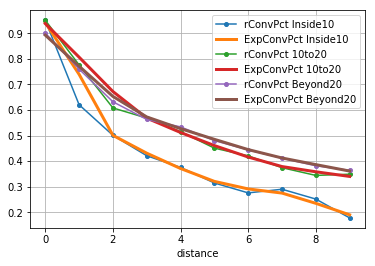

In [8]:
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region = conv_pct.loc[region]
    conv_pct.loc[region, 'ExpConvPct'] = curve_fit(
        conv_pct_region.index, conv_pct_region['rConvPct'])
    
exp_conv_pct_model = conv_pct['ExpConvPct']

fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'Inside10'), (('C2', 'C3'), '10to20'), (('C4', 'C5'), 'Beyond20')]
for (clr1, clr2), region in it:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=clr1, marker='.', ms=8, label='rConvPct ' + region)
    conv_pct.loc[region].plot(
        ax=ax, y='ExpConvPct', color=clr2, lw=3, label='ExpConvPct ' + region)

ax.legend(loc=1)
ax.grid()

# 3. PUNT

In [39]:
punt_dist = punts.\
    groupby('yrdline100')['net_punt_dist'].\
    mean().\
    to_frame()
punt_dist.columns = ['rExpNetPuntDist']  # Update column names
punt_dist.fillna(method = 'ffill', inplace=True)

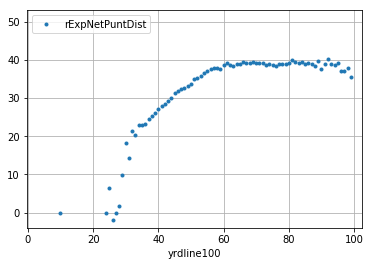

In [40]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

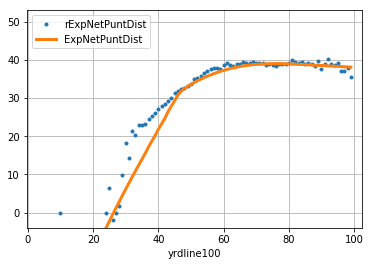

In [42]:
punt_dist['ExpNetPuntDist'] = curve_fit(punt_dist.index, punt_dist['rExpNetPuntDist'])

exp_net_punt_dist_model = punt_dist['ExpNetPuntDist']

ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
punt_dist.plot(y='ExpNetPuntDist', ax=ax, lw=3)
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

# 4. FIELD GOALS Probability

In [11]:
# 1. Group by distance 
# 2. Take the average success rate
# 3. Convert to DataFrame instead of Series
# 4. Make the index a column instead
fg_prob = fgs.\
    groupby('FieldGoalDistance')['FieldGoalSuccess'].\
    mean().\
    to_frame()
fg_prob.columns = ['rFieldGoalProb']  # Update column names
fg_prob

,rFieldGoalProb
FieldGoalDistance,
-43.0,0.000000
0.0,0.600000
3.0,0.000000
4.0,0.000000
5.0,0.000000
6.0,0.000000
7.0,0.000000
8.0,0.000000
9.0,0.000000


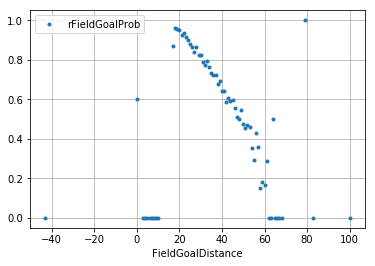

In [16]:
ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
ax.legend(loc=0)
ax.grid()

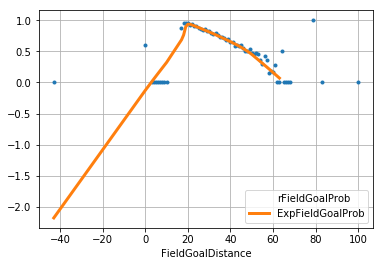

In [15]:
under_63_mask = fg_prob.index <= 63.
fg_under_63 = fg_prob.loc[under_63_mask]

fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'] = curve_fit(
    fg_under_63.index, fg_under_63['rFieldGoalProb'])

exp_fg_prob_model = fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'].copy()

ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
fg_prob.plot(y='ExpFieldGoalProb', ax=ax, lw=3)
ax.grid()

In [43]:
fg_under_63

,rFieldGoalProb,ExpFieldGoalProb
FieldGoalDistance,,
18.0,0.959770,0.970286
19.0,0.958738,0.957192
20.0,0.943056,0.944065
21.0,0.929032,0.930909
22.0,0.926108,0.917730
23.0,0.910773,0.904536
24.0,0.894855,0.891328
25.0,0.881207,0.878102
26.0,0.853933,0.864842


In [43]:
def build_decision_maker(ekv, epv_model, exp_conv_pct_model, 
                         exp_net_punt_dist_model, exp_fg_prob_model):
    
    YRDSTOGO_CAP = 10  # Model restriction
    PUNT_LIM = 29      # Model restriction
    FG_LIM = 63        # Model restriction
    FG_OFFSET = 8      # Field goal placement distance (not including the 10 for the endzone)
    FG_FAIL_RESET = 0  # Where the ball is placed after a failed field goal.  If 0, at the spot.  
                       # Otherwise, at the spot or at the reset spot, whichever is better.
    
    def decision_maker(yrdline100, ydstogo, print_message=False):
        if yrdline100 < 10:
            region = 'Inside10'
        elif yrdline100 < 20:
            region = '10to20'
        else:
            region = 'Beyond20'
            
        # 1. Expected value of going for it
        
        # Value of failing (approximately turning over at same spot)
        conv_fail_yrdline100 = 100 - yrdline100
        conv_fail_epv = -epv_model[conv_fail_yrdline100] 
        
        # Value of converting (approximately at the first down marker)
        if yrdline100 == ydstogo:
            conv_succ_epv = 7 - ekv
        else:
            first_down_yrdline100 = yrdline100 - ydstogo
            conv_succ_epv = epv_model[first_down_yrdline100]

        # Conversion Pct
        exp_conv_pct = exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
        
        # Overall expected value of going for it
        go_ev = exp_conv_pct * conv_succ_epv + (1 - exp_conv_pct) * conv_fail_epv
        
        # 2. Expected value of punting
        
        # Expected next yardline
        if yrdline100 >= PUNT_LIM:
            exp_net_punt_dist = exp_net_punt_dist_model[yrdline100]
            exp_yrdline100 = 100 - yrdline100 + int(exp_net_punt_dist)
            
            # Overall expected value of punting
            punt_ev = -epv_model[exp_yrdline100]
        else:
            punt_ev = None
            
        # 3. Expected value of kicking a field goal
        fg_dist =  yrdline100 + 10 + FG_OFFSET
        if fg_dist <= FG_LIM:
            # Probability of success
            exp_fg_prob = exp_fg_prob_model[fg_dist ]

            # Expected value of field success
            fg_succ_epv = 3 - ekv

            # EPV of field goal fail
            fg_fail_yrdline100 = 100 - yrdline100 - FG_OFFSET
            fg_fail_epv = -epv_model[fg_fail_yrdline100]

            # Overall expected value kicking
            fg_ev = fg_succ_epv * exp_fg_prob + fg_fail_epv * (1 - exp_fg_prob)
        else:
            fg_ev = None
    
        choices = [('go for it', go_ev), ('punt', punt_ev), ('kick', fg_ev)]
        max_val = -100
        for choice, ev in choices:
            if ev is None:
                continue
            if ev > max_val:
                max_val = ev
                decision = choice
    
        if print_message:
            print("Expected Values")
            print("Go for it: {:.2f}".format(go_ev))
            if punt_ev is not None:
                print("Punt: {:.2f}".format(punt_ev))
            else:
                print("Punt: TOO CLOSE TO PUNT")
            if fg_ev is not None:
                print("FG: {:.2f}".format(fg_ev))
            else:
                print("FG: TOO FAR TO KICK")        

            print()
            print("Coach, you should:")
            print(decision.upper())

        return decision
    
    return decision_maker

# Build the decision maker
decision_maker = build_decision_maker(
    ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, exp_fg_prob_model)

In [44]:
yrdlines = list(range(1, 100))
down_dist = list(range(1, 10))

decisions = []
for yrdstogo in down_dist:
    tmp = []
    for yrdline in yrdlines:
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            decision = decision_maker(yrdline, yrdstogo)
            tmp.append(decision)
        else:
            tmp.append(None)
    decisions.append(tmp)
# Convert to a table
pd.DataFrame(decisions, columns=yrdlines, index=down_dist)

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
1,go for it,kick,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,None,None,None,None,None,None,None,None
2,None,go for it,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,None,None,None,None,None,None,None
3,None,None,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,None,None,None,None,None,None
4,None,None,None,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,None,None,None,None,None
5,None,None,None,None,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,go for it,None,None,None,None
6,None,None,None,None,None,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,go for it,go for it,None,None,None
7,None,None,None,None,None,None,kick,kick,kick,kick,...,punt,punt,punt,punt,punt,punt,punt,punt,None,None
8,None,None,None,None,None,None,None,kick,kick,kick,...,punt,punt,punt,punt,punt,punt,punt,punt,punt,None
9,None,None,None,None,None,None,None,None,kick,kick,...,punt,punt,punt,punt,punt,punt,punt,punt,punt,punt


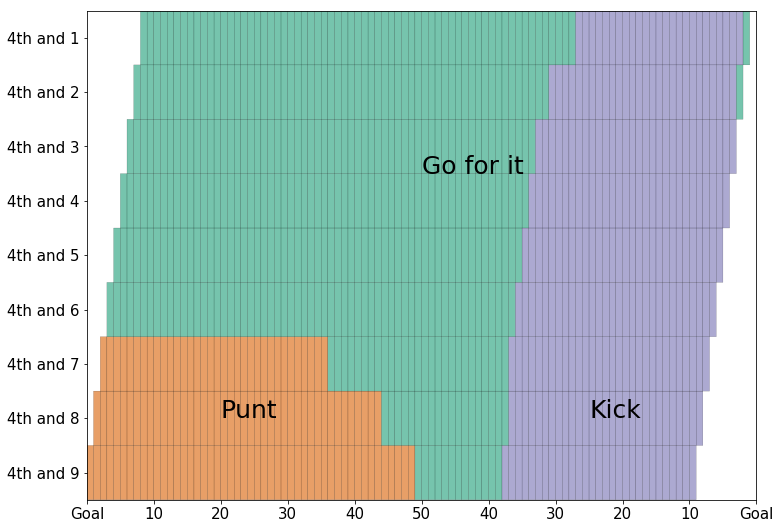

In [45]:
import numpy as np
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = decisions[i][j]
        if decision == 'go for it':
            val = 1
        elif decision == 'punt':
            val = 2
        elif decision == 'kick':
            val = 3
        elif decision is None:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin=1,
    vmax=8,
    edgecolors='k', 
    linewidths=.2,
    cmap=plt.get_cmap('Dark2'),
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['Goal', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([
    yd - .5
    for yd in range(1, 10)
])
ax.set_yticklabels([
    '4th and {}'.format(yd)
    for yd in range(9, 0, -1)
])
ax.text(50, 6, 'Go for it', size=25)
ax.text(20, 1.5, 'Punt', size=25)
ax.text(75, 1.5, 'Kick', size=25)
ax.tick_params(axis='both', which='major', labelsize=15);